In [2]:
import glob
import os

import graphviz
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
from IPython.display import IFrame
from sklearn import tree
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split

from core.postprocess_service import PostprocessService

import matplotlib.pyplot as mp
import seaborn as sb

In [3]:
# load global vars
postproc_srv = PostprocessService()
basedir = "/home/ymerel/storage/private/ymerel/results/auditory"
mean_path = os.path.join(basedir, 'mean_result.nii')
df_path = os.path.join(basedir, 'dataset.csv')
ids = []
results = []
paths = glob.glob(os.path.join(basedir, '*/'), recursive=True)
for path in paths:
    ids.append(os.path.basename(os.path.dirname(path)))
    results.append(os.path.join(path, '_subject_id_01', 'result.nii'))

In [4]:
# Write mean image from result
mean_nifti_image = postproc_srv.get_mean_image(results, 10)
nib.save(mean_nifti_image, mean_path)

In [5]:
# Load dataset as dataframe and write it as CSV
dataframe = postproc_srv.get_dataframe(basedir, ids)
dataframe.to_csv(df_path, index=False, sep=';')

Text(0, 0.5, 'Frequency')

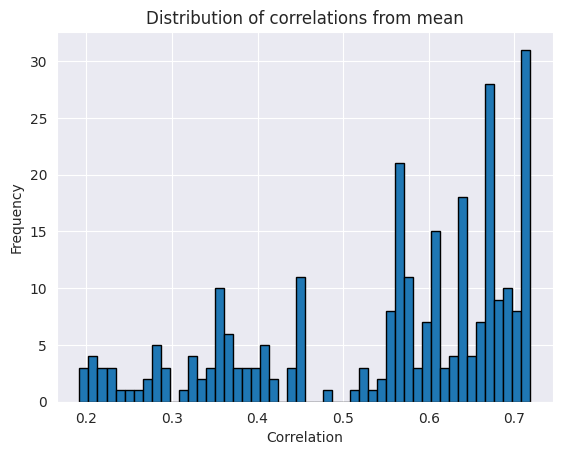

In [32]:
# Correlations from mean distribution
plt.hist(dataframe['from_mean'], bins=50, edgecolor='black')
plt.title('Distribution of correlations from mean')
plt.xlabel('Correlation')
plt.ylabel('Frequency')

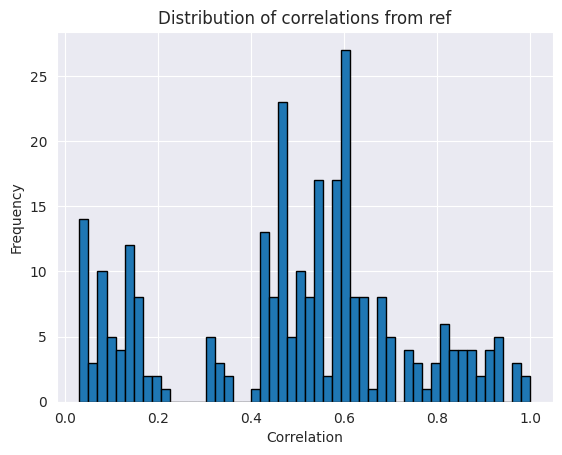

In [33]:
# Correlations from ref distribution
plt.hist(dataframe['from_ref'], bins=50, edgecolor='black')
plt.title('Distribution of correlations from ref')
plt.xlabel('Correlation')
plt.ylabel('Frequency')
plt.show()

In [34]:
metric = "from_mean"

# Prepare dataset
ref_row = dataframe[dataframe['id'] == 'ref'].index
X = dataframe.drop(columns=["id", "from_mean", "from_ref"]).drop(ref_row)
y = dataframe[metric].drop(ref_row)

test_size=0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

In [35]:
# Train model
reg = tree.DecisionTreeRegressor(max_depth=4)
reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [36]:
# Test model
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"[{metric}] Mean absolute error (MAE) : {mean_absolute_error(y_test, reg.predict(X_test))}" )
print(f"[{metric}] Mean squared error (MSE) : {mean_squared_error(y_test, reg.predict(X_test))}" )
print(f"[{metric}] Mean absolute percentage error (MAPE) : {mean_absolute_percentage_error(y_test, reg.predict(X_test))}" )

[from_mean] Mean absolute error (MAE) : 0.01805431371499657
[from_mean] Mean squared error (MSE) : 0.0005422613005446125
[from_mean] Mean absolute percentage error (MAPE) : 3.462570010114449


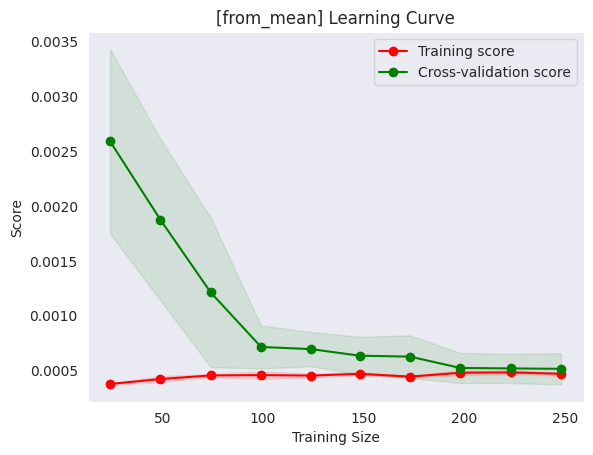

In [37]:
# learning curve
# Define the range of training sizes
train_sizes = np.linspace(0.1, 1.0, 10)

# Compute the learning curve
train_sizes, train_scores, test_scores = learning_curve(
    reg, X, y, train_sizes=train_sizes, cv=10, scoring='neg_mean_squared_error'
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.plot(train_sizes, -train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, -test_mean, 'o-', color='g', label='Cross-validation score')
plt.fill_between(train_sizes, -train_mean - train_std, -train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, -test_mean - test_std, -test_mean + test_std, alpha=0.1, color='g')
plt.grid()
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title(f'[{metric}] Learning Curve')
plt.legend(loc='best')
plt.show()

In [38]:
# Display tree
def print_tree(clf, f_names, name):
    
    dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=f_names,  
                         filled=True, rounded=True,
                         special_characters=True)  
    graph = graphviz.Source(dot_data)  
    graph.render(name)
    
print_tree(reg, X_train.columns.values, f"tree_{metric}")

filepath = f"tree_{metric}.pdf"
IFrame(filepath, width=700, height=500)

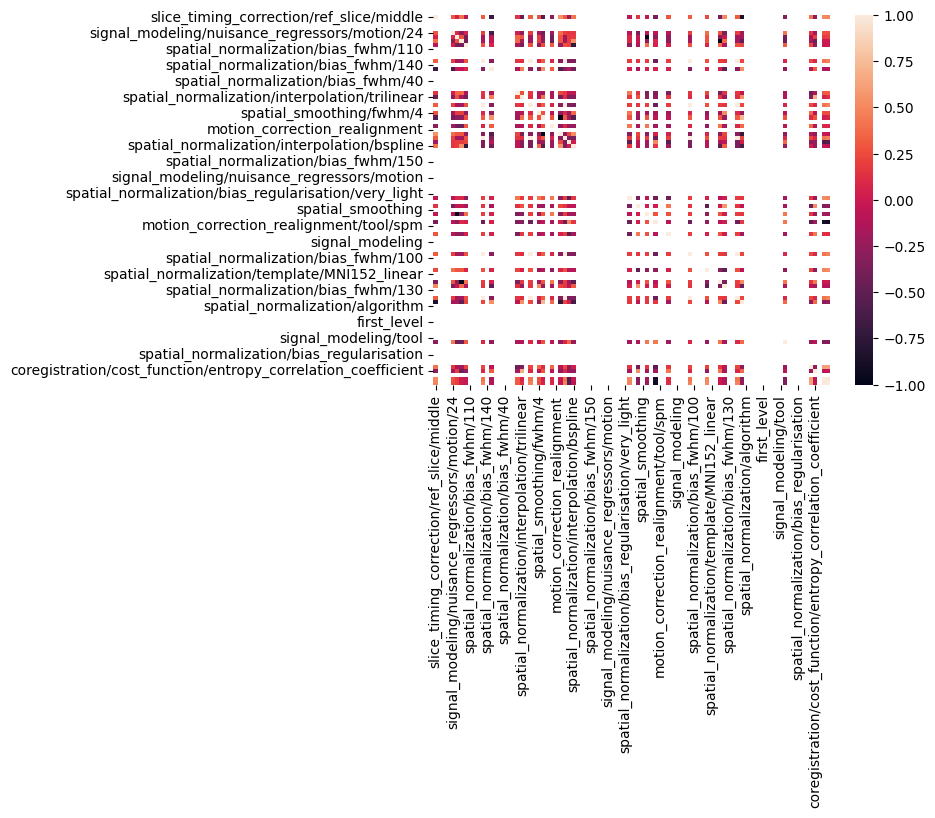

In [95]:
# https://www.geeksforgeeks.org/how-to-create-a-seaborn-correlation-heatmap-in-python/

for nii in results:
    dataframes.append(self.stat_srv.compute_correlations(nii, niis))

# Plotting correlation heatmap
dataplot = sb.heatmap(dataframe.corr(numeric_only=True))

# Displaying heatmap
mp.show()